In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision

from torch.optim import SGD
from torchvision.transforms import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu train và validation.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [2]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])



trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

valset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [01:09<00:00, 2449283.94it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


+ Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing

Batch 1


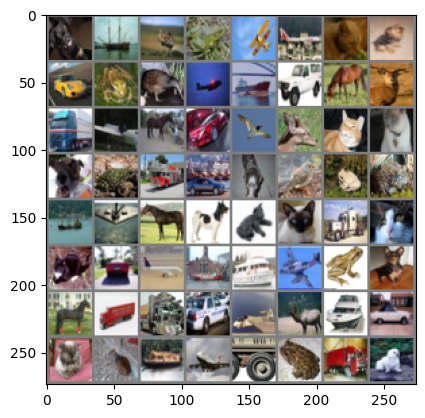

In [3]:
def imshow(img):
	img = img / 2 + 0.5
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
	print(f"Batch {i+1}")
	imshow(torchvision.utils.make_grid(images))
	if i == 0:
		break

+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [4]:
def getModel(n_features):
	model = nn.Sequential(
		nn.Flatten(),
		nn.Linear(n_features, 512),
		nn.ReLU(),
		nn.Linear(512, 256),
		nn.ReLU(),
		nn.Linear(256, 10)
	)
	return model


+ Khởi tạo hàm loss function và phương thức optimizer

In [5]:
n_features = 32 * 32 *3
model = getModel(n_features).to(device)
lr = 0.1
optim = SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

model


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=True)
)

+ Xây dựng hàm đánh giá model

In [6]:
def evaluate(model, testloader, criterion):
	model.eval()
	test_loss = 0.0
	correct = 0
	total = 0
	with torch.no_grad():
		for images, labels in testloader:
			images, labels = images.to(device), labels.to(device)
			outputs = model(images)
			loss = criterion(outputs, labels)
			test_loss += loss.item()
			
			_, predicted = torch.max(outputs.data, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	
	accuracy = 100 * correct / total
	test_loss = test_loss / len(testloader)
	return test_loss, accuracy

+ Bắt đầu training và đánh giá model.

In [7]:
n_epochs = 100
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
	running_loss = 0.0
	running_correct = 0
	total = 0
	model.train()
	for i, (inputs, labels) in enumerate(trainloader, 0):
		inputs, labels = inputs.to(device), labels.to(device)

		optim.zero_grad()

		outputs = model(inputs)
		loss = loss_fn(outputs, labels)
		loss.backward()
		optim.step()

		running_loss += loss.item()
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		running_correct += (predicted == labels).sum().item()

	epoch_accuracy = 100 * running_correct / total
	epoch_loss = running_loss / (i + 1)
	test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
	print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

	train_losses.append(epoch_loss)
	train_accuracies.append(epoch_accuracy)
	test_losses.append(test_loss)
	test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 1.6840, Accuracy: 40.03%, Test Loss: 1.5991, Test Accuracy: 43.19%
Epoch [2/100], Loss: 1.4448, Accuracy: 49.07%, Test Loss: 1.5083, Test Accuracy: 47.07%
Epoch [3/100], Loss: 1.3244, Accuracy: 53.22%, Test Loss: 1.5080, Test Accuracy: 47.59%
Epoch [4/100], Loss: 1.2319, Accuracy: 56.50%, Test Loss: 1.5054, Test Accuracy: 48.59%
Epoch [5/100], Loss: 1.1512, Accuracy: 59.30%, Test Loss: 1.4864, Test Accuracy: 49.51%
Epoch [6/100], Loss: 1.0814, Accuracy: 61.62%, Test Loss: 1.3560, Test Accuracy: 53.41%
Epoch [7/100], Loss: 1.0128, Accuracy: 64.11%, Test Loss: 1.3942, Test Accuracy: 52.75%
Epoch [8/100], Loss: 0.9463, Accuracy: 66.50%, Test Loss: 1.4222, Test Accuracy: 53.82%
Epoch [9/100], Loss: 0.8823, Accuracy: 68.69%, Test Loss: 1.4698, Test Accuracy: 52.67%
Epoch [10/100], Loss: 0.8166, Accuracy: 71.11%, Test Loss: 1.4663, Test Accuracy: 53.18%
Epoch [11/100], Loss: 0.7591, Accuracy: 72.95%, Test Loss: 1.5960, Test Accuracy: 52.21%
Epoch [12/100], Loss: 0.6989, 

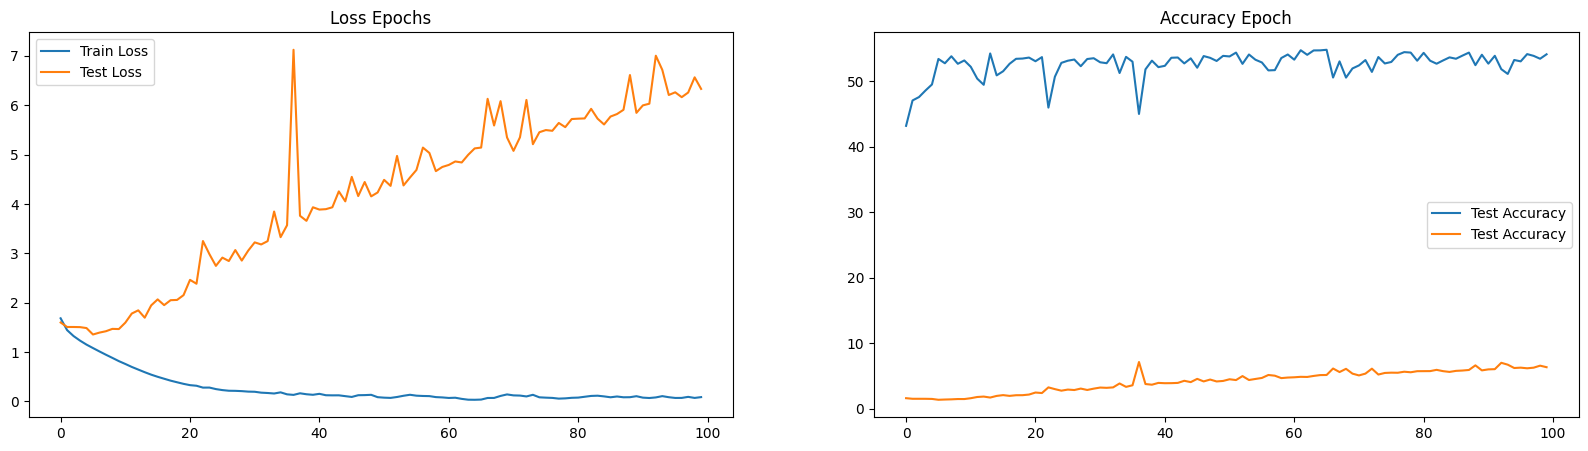

In [8]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.plot(test_losses, label = 'Test Accuracy')
plt.legend()

+ Dưới đây là bài tập về code from scratch

In [9]:
def zScoreScaling(tensor):
    mean = tensor.mean(dim=0, keepdim=True)
    std = tensor.std(dim=0, keepdim=True)
    return (tensor - mean) / std

In [10]:
def minMaxScaling(tensor):
    min_val = tensor.min(dim=0, keepdim=True).values
    max_val = tensor.max(dim=0, keepdim=True).values
    return (tensor - min_val) / (max_val - min_val)

In [11]:
class Linear:
    def __init__(self, in_features, out_features):
        # Khởi tạo trọng số và bias với giá trị ngẫu nhiên
        self.weight = torch.randn(out_features, in_features)
        self.bias = torch.randn(out_features)

    def forward(self, x):
        return torch.matmul(self.weight, x) + self.bias


In [12]:
tensor = torch.tensor([
    [1.0, 2.0, 3.0], 
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
zscore = zScoreScaling(tensor)
min_max = minMaxScaling(tensor)
print(zscore)
print(min_max)


tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])
tensor([[0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000],
        [1.0000, 1.0000, 1.0000]])


In [13]:
tensor = torch.tensor([1.0, 2.0, 3.0])
linear = Linear(3, 2)
out = linear.forward(tensor)
print(out)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")

tensor([ 6.4619, -2.1053])
Weight = tensor([[-0.6848,  0.2297,  1.9808],
        [ 0.3421,  2.9466, -2.5736]])
Bias = tensor([ 0.7449, -0.6198])
